## PyTorch【第一周】计算图与动态图机制

##### 1.Computational Graph
      1）用来描述运算的有向无环图，Node(表示数据：向量，矩阵，张量) & Edge（表示运算：加减乘除卷积等）  
      2）叶子节点：用户创建的节点称为叶子节点，is_leaf 指示张量是否为叶子节点。grad_fn:创建导函数     

In [14]:
import torch

w = torch.tensor([1.],requires_grad = True)
x = torch.tensor([2.],requires_grad = True)

a = torch.add(w,x)
a.retain_grad()
b = torch.add(w,1)

y0 = torch.mul(a,b)
y1 = torch.add(a,b)
#y0=(w+x)(w+1)  求dy0/dw=5
#y1 = (w+x)+(w+1) dy1/dw=2
#y0.backward()
#print(w.grad)

In [9]:
print('is_leaf:\n',w.is_leaf,x.is_leaf,a.is_leaf,b.is_leaf,y0.is_leaf)
print('gradient:\n',w.grad,x.grad,a.grad,b.grad,y0.grad)
print('gradient function:\n',w.grad_fn,x.grad_fn,a.grad_fn,b.grad_fn,y0.grad_fn)

is_leaf:
 True True False False False
gradient:
 tensor([5.]) tensor([2.]) tensor([2.]) None None
gradient function:
 None None <AddBackward0 object at 0x0000022961CFE3E0> <AddBackward0 object at 0x0000022961CFF130> <MulBackward0 object at 0x0000022956D80490>


C:\Users\liwen\AppData\Local\Temp\ipykernel_33196\63324297.py:2: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\b\abs_abjetg6_iu\croot\pytorch_1686932924616\work\build\aten\src\ATen/core/TensorBody.h:491.)
  print('gradient:\n',w.grad,x.grad,a.grad,b.grad,y.grad)


#### 2.Dynamic vs. Static Computational Graphs
        1)动态图：运算与搭建同时进行
        2）静态图：先搭建图，后运算（Tensorflow)   
####  Autograd
         1)torch.autograd.backward(tensors用于求导的张量，如loss，retain_graph=None/True保存计算图，create_graph创建倒数计算图用于高阶求导， grad_tensors=None多梯度权重)：
         2）torch.autograd.grad（outputds:loss,inputs:需要梯度的张量，create_graph,retain_graph,grad_outputs）:求取梯度
         3)梯度不自动清零，依赖于叶子结点的结点，requrires_grad默认为True,叶子结点不可执行in-place(在原始内存id中改变这个数据,+=)：因为在求导过程中前向转播记录了叶子结点的地址，反向传播的过程中需要被引用到，如果数据变了求导会出现错误。

In [15]:
loss = torch.cat([y0,y1],dim=0) #[y0,y1]
#print(loss)
grad_tensors = torch.tensor([1.,1.])#5*1+2*1=7 权重的设置
loss.backward(gradient=grad_tensors)#传入torch.autograd.backward
print(w.grad)

tensor([6., 5.], grad_fn=<CatBackward0>)
tensor([7.])


In [20]:
x = torch.tensor([3.],requires_grad=True)
y = torch.pow(x,2) #y=x**2

grad_1 = torch.autograd.grad(y,x,create_graph=True) #grad1 = dy/dx = 2x = 2*3=6
print(grad_1)

grad_2 = torch.autograd.grad(grad_1[0],x)#grad2=d(2x)/dx=2
print(grad_2)
w.grad.zero_()

(tensor([6.], grad_fn=<MulBackward0>),)
(tensor([2.]),)


tensor([0.])

In [29]:
w = torch.tensor([1.],requires_grad=True)
x = torch.tensor([2.],requires_grad=True)


for i in range(8):
    a = torch.add(w,x)
    b = torch.add(w,1)
    y = torch.mul(a,b)
    
    y.backward()
    print(w.grad)

tensor([5.])
tensor([10.])
tensor([15.])
tensor([20.])
tensor([25.])
tensor([30.])
tensor([35.])
tensor([40.])


##### Logistic Regression: 线性的二分类模型
\begin{equation}
y=f(WX+b)\\
f(x)=\frac{1}{1+e^{-x}}\cdots \text{Sigmoid/Logistic function}\\
y=\frac{1}{1+e^{-(WX+b)}}\rightarrow
ln\frac{y}{1-y}=WX+b \cdots \text{对数几率回归}
\label{eq:1}
\end{equation}

\begin{equation}
class=\left\{
\begin{aligned}
0, & & {y<0.5}\\
1, & & {y \geq 0.5}
\end{aligned}\right.
\end{equation}





In [37]:
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(10)

In [33]:
#generate data
sample_nums = 100
mean_value = 1.7
bias = 1
n_data = torch.ones(sample_nums,2)
x0 = torch.normal(mean_value*n_data, 1) + bias #类别0的数据 shape（100，2）
y0 = torch.zeros(sample_nums)                  #类别0的标签 shape（100，1）
x1 = torch.normal(-mean_value*n_data,1) + bias #类别1的数据 shape（100，2）
y1 = torch.ones(sample_nums)                   #类别1的标签 shape（100，1）
train_x = torch.cat((x0,x1),0)

train_y = torch.cat((y0,y1),0)

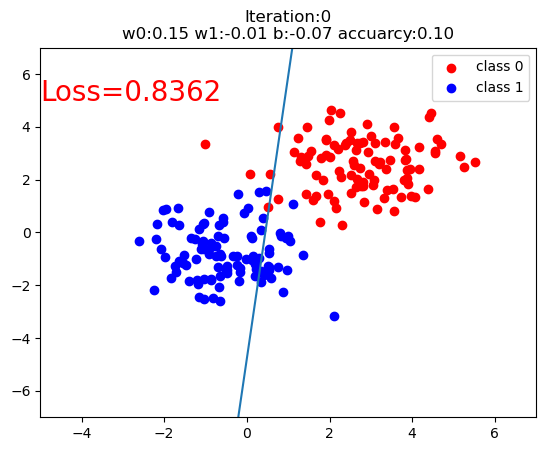

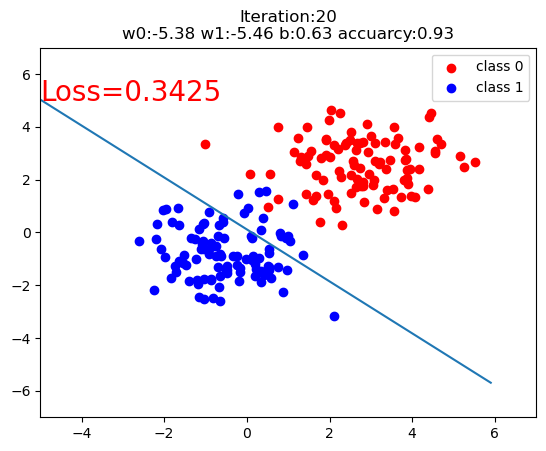

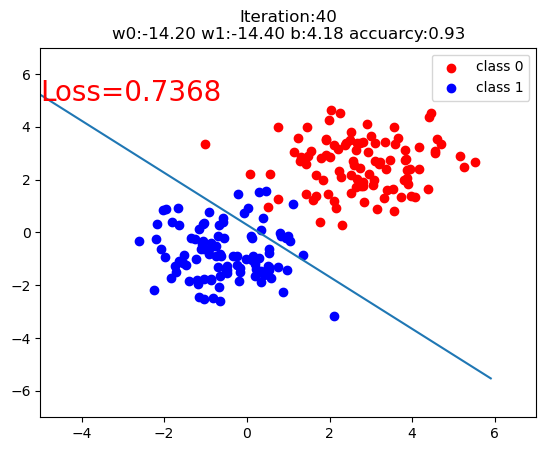

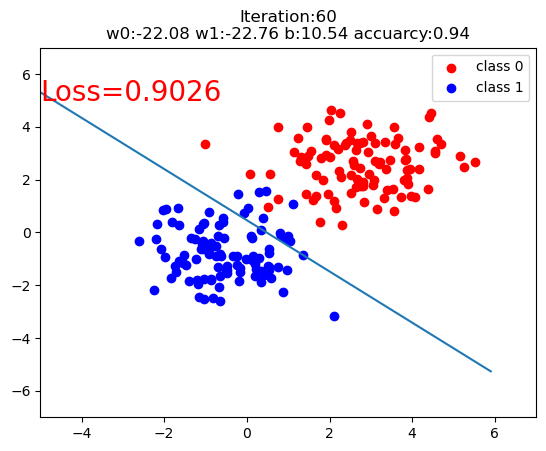

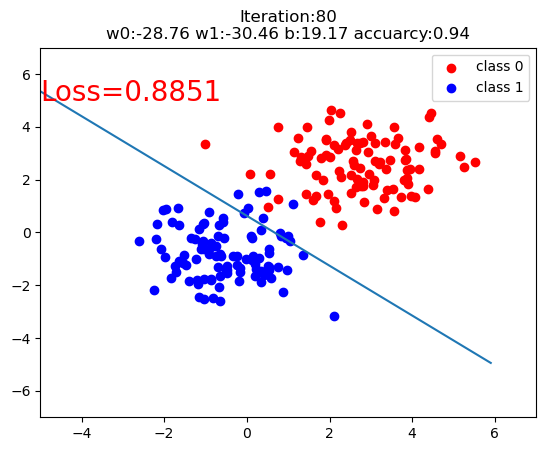

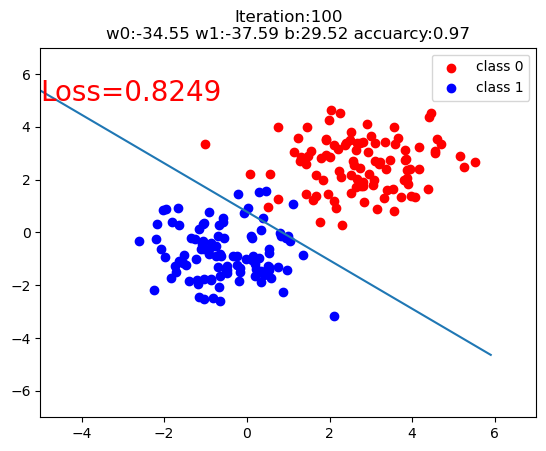

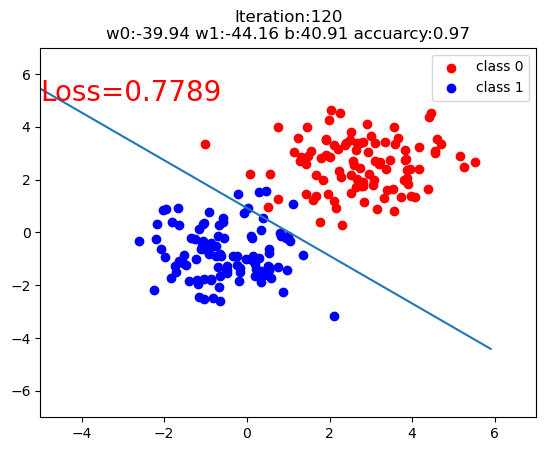

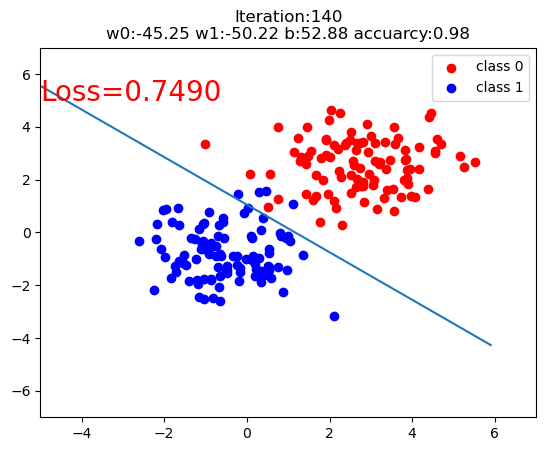

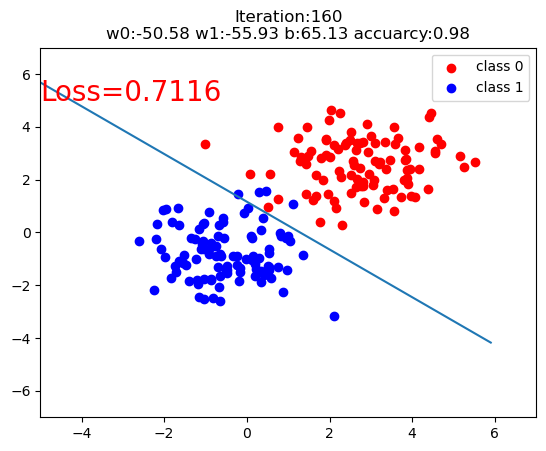

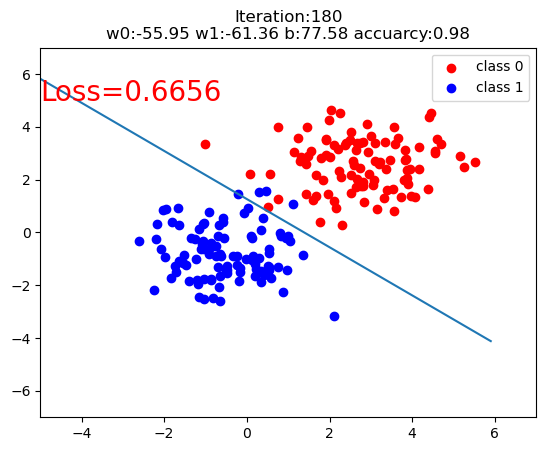

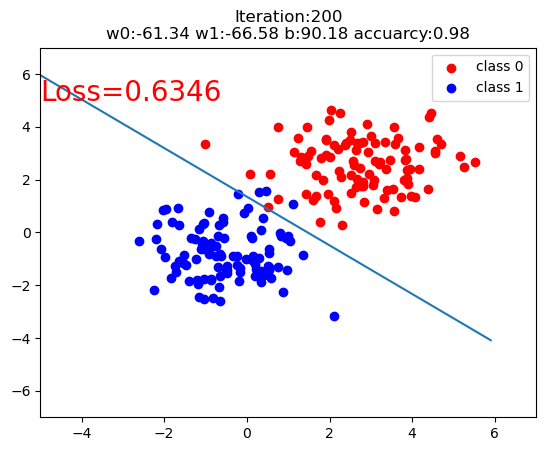

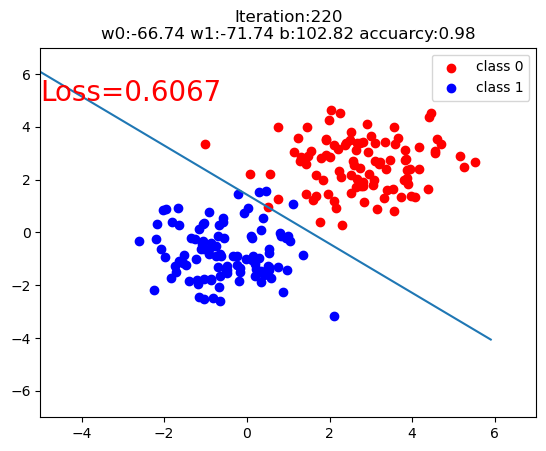

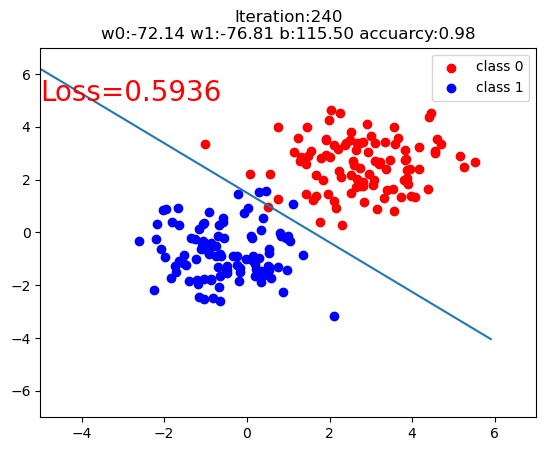

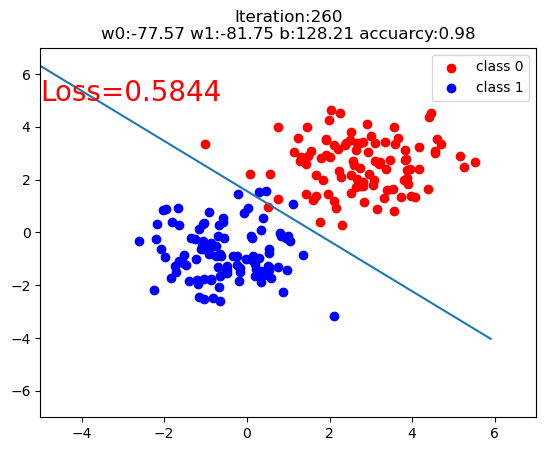

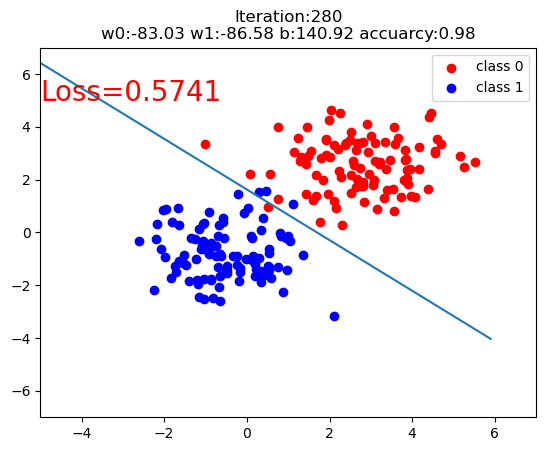

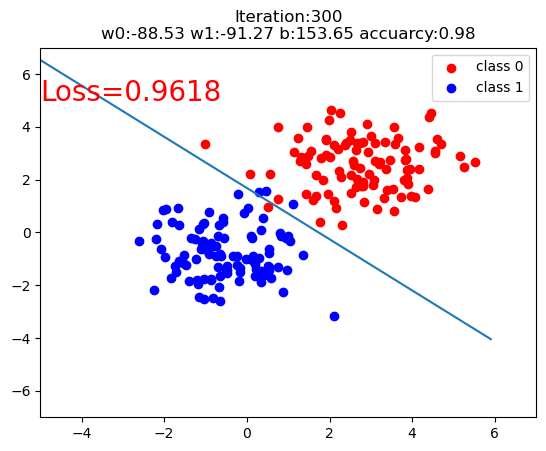

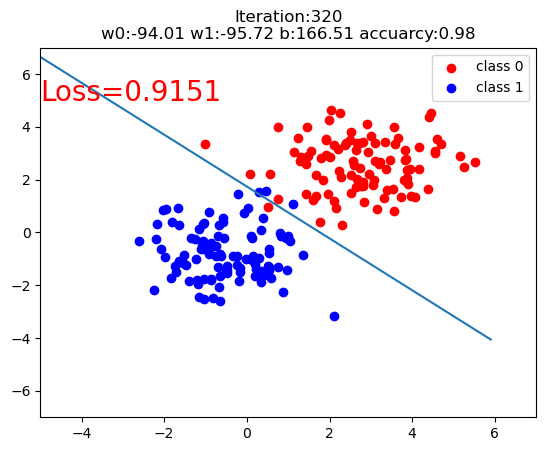

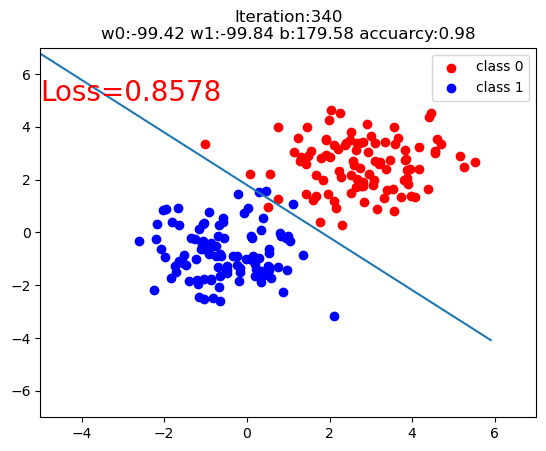

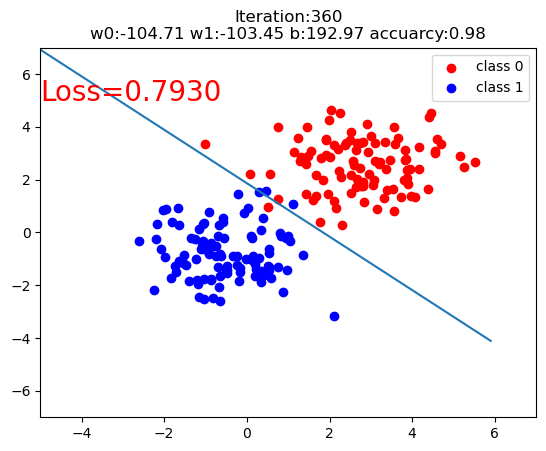

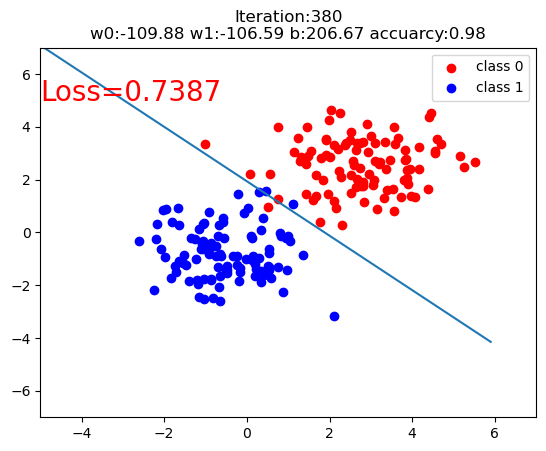

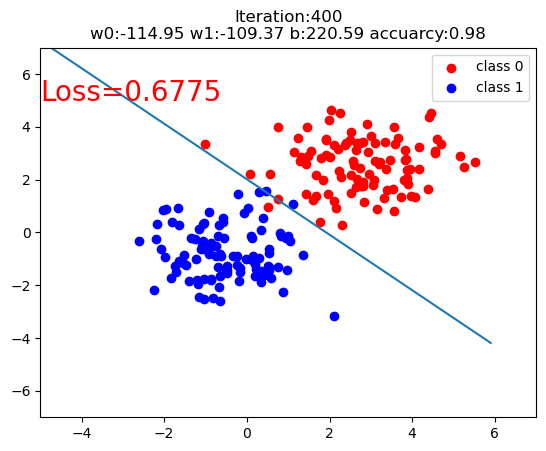

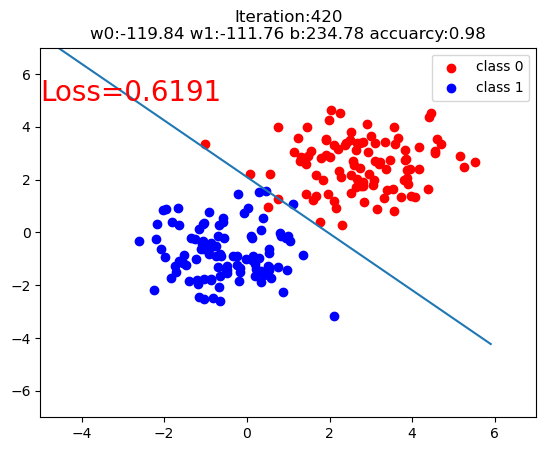

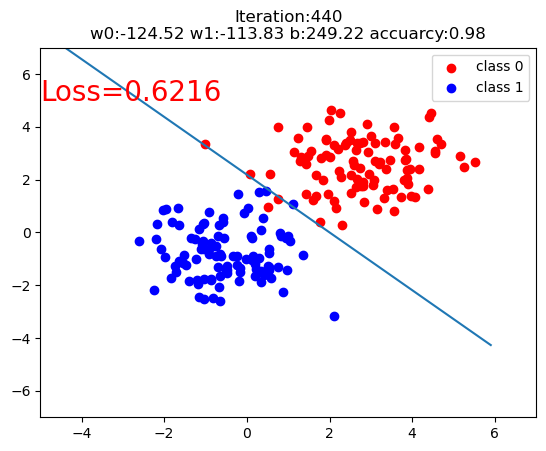

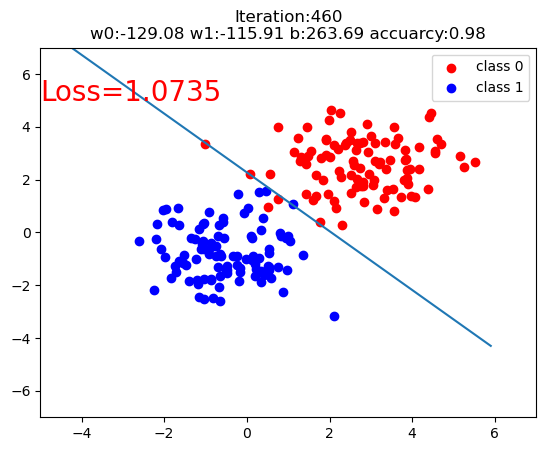

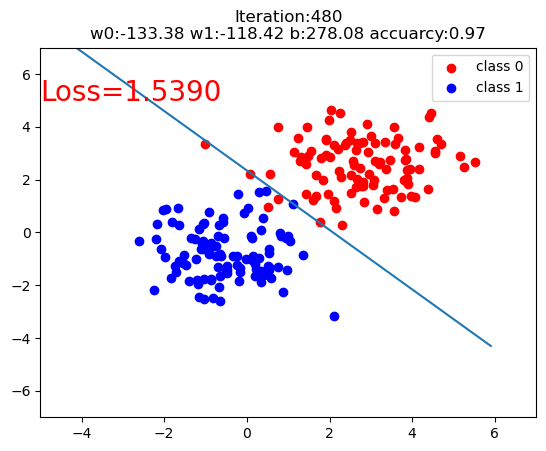

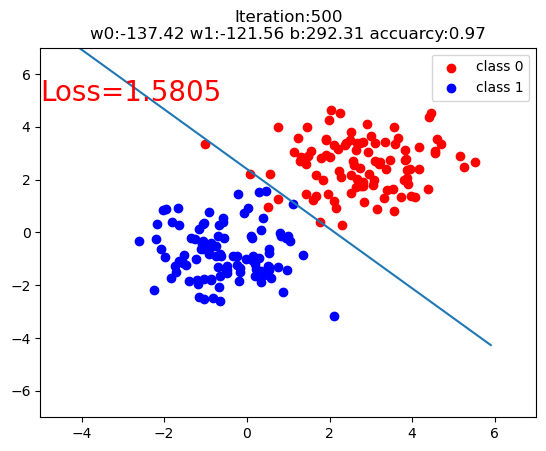

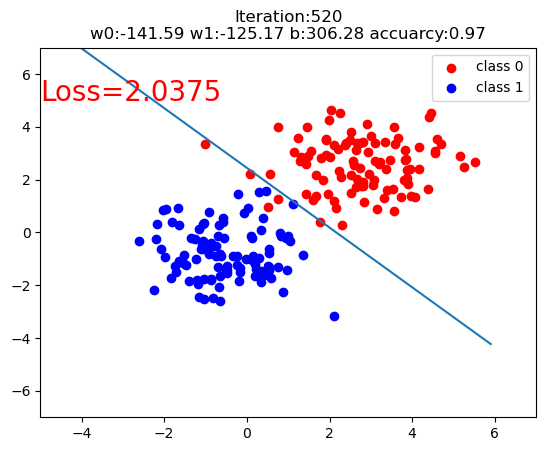

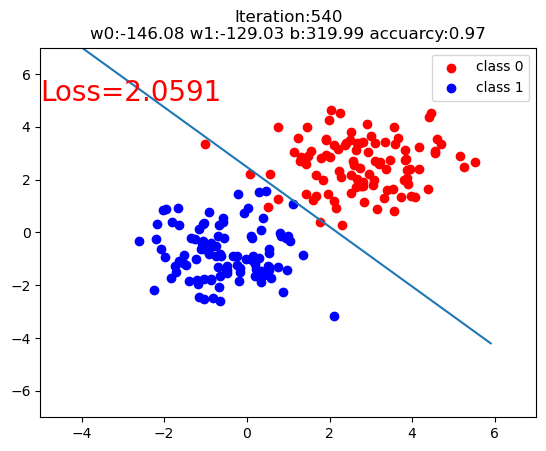

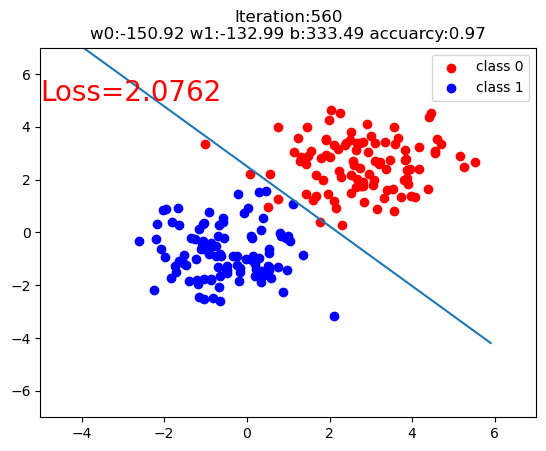

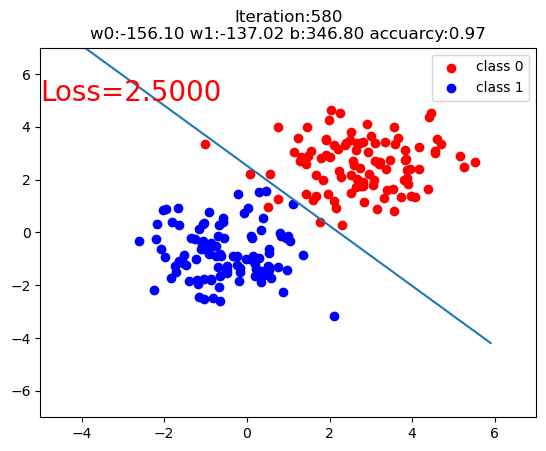

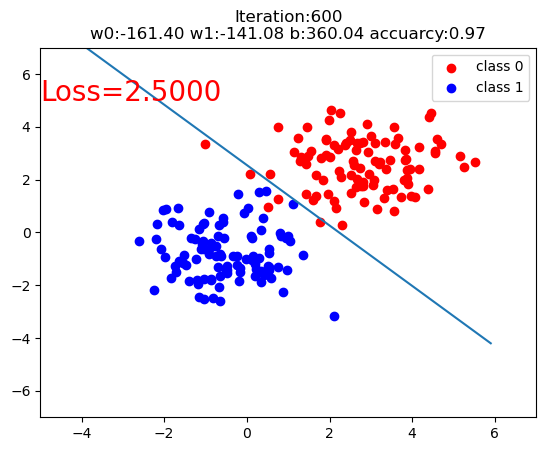

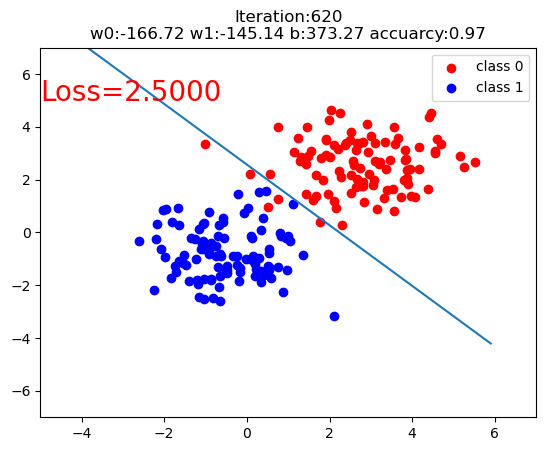

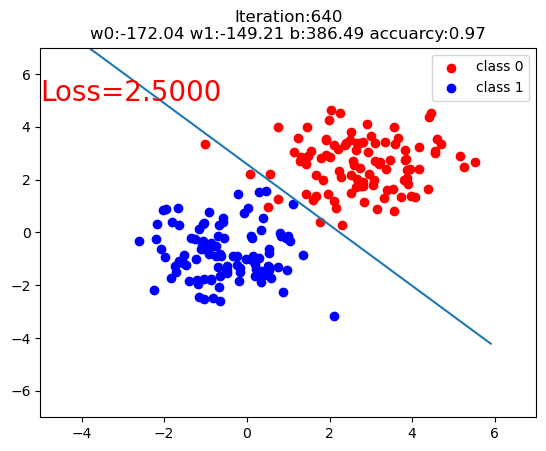

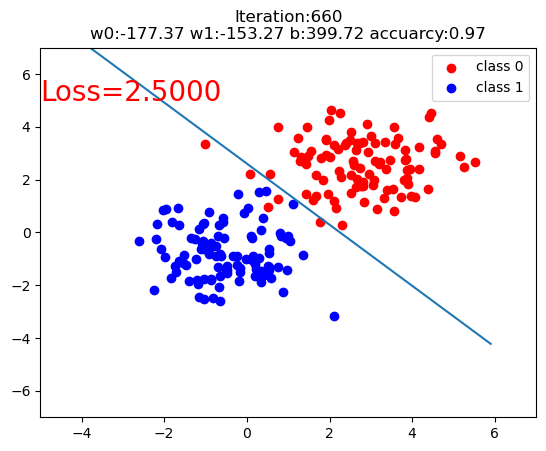

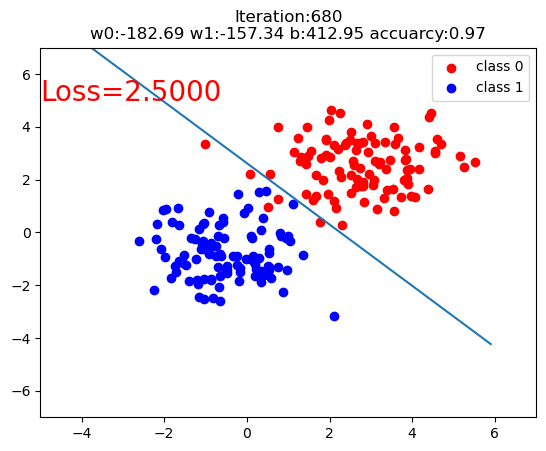

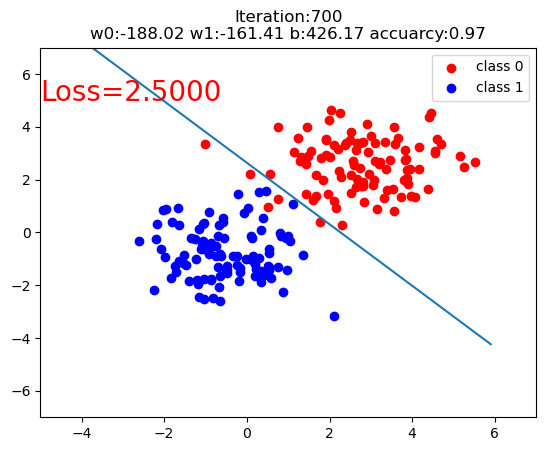

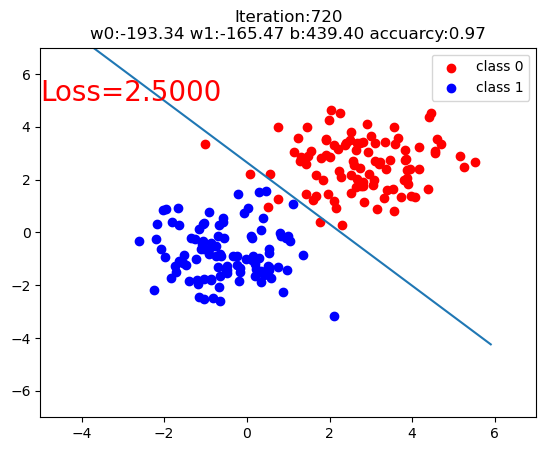

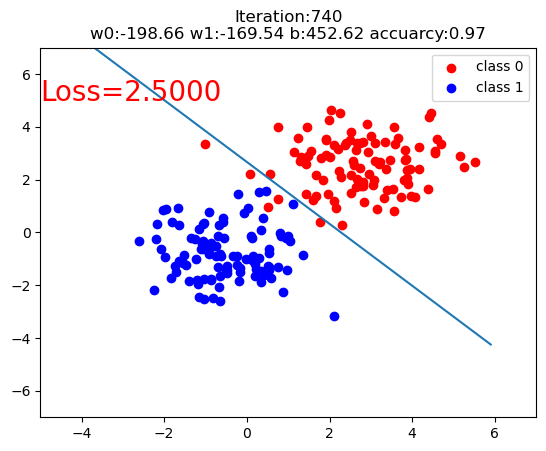

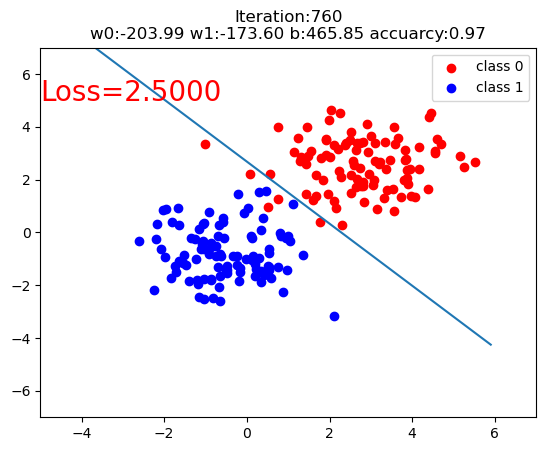

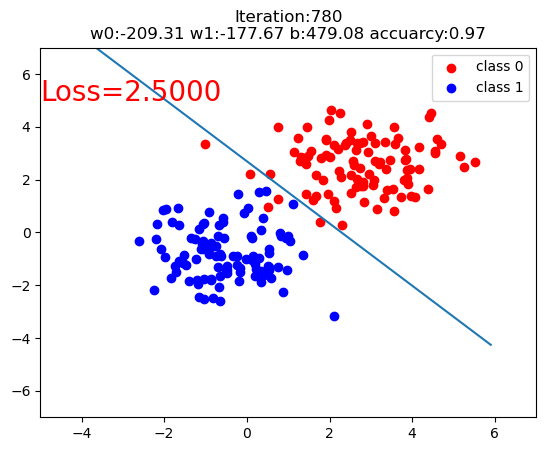

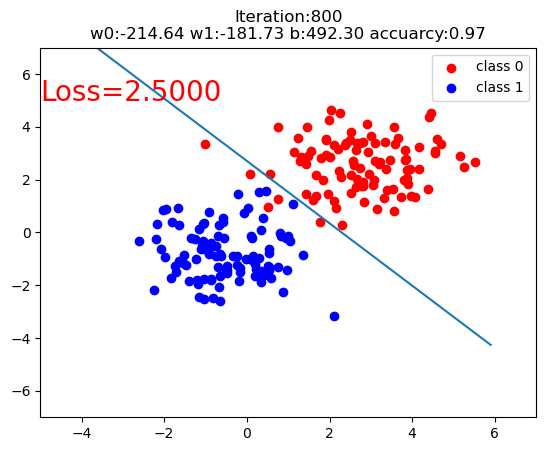

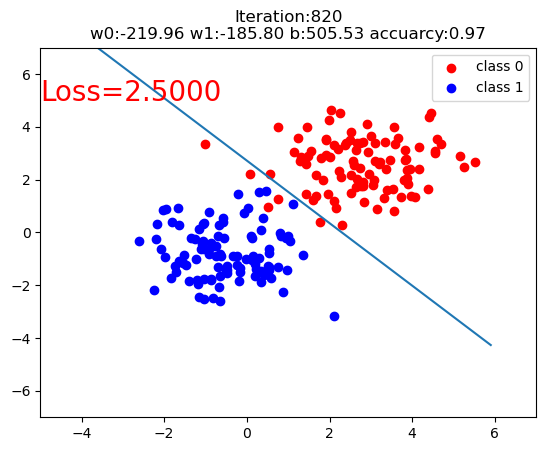

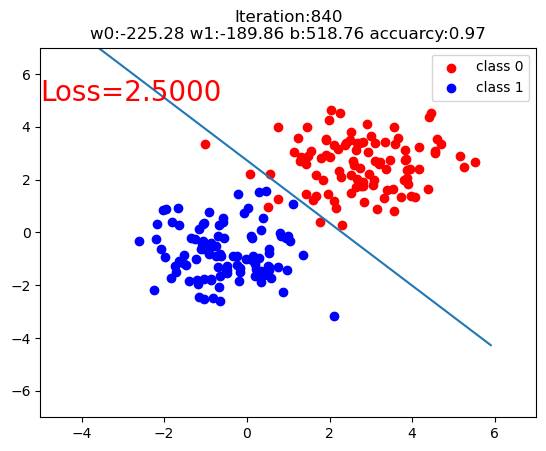

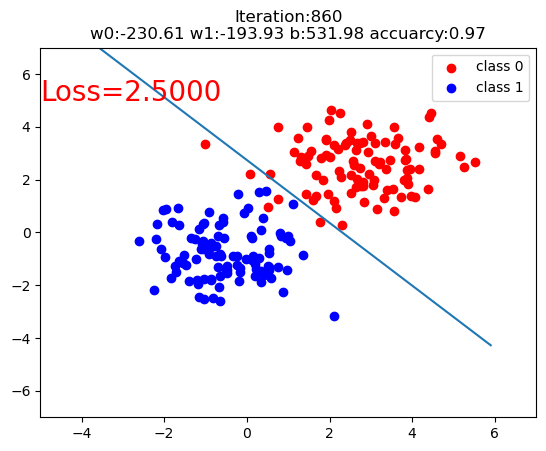

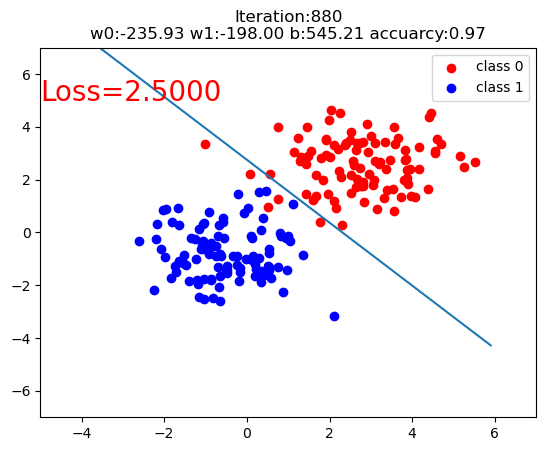

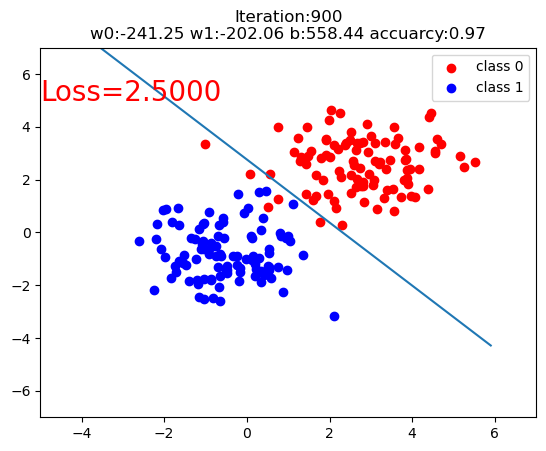

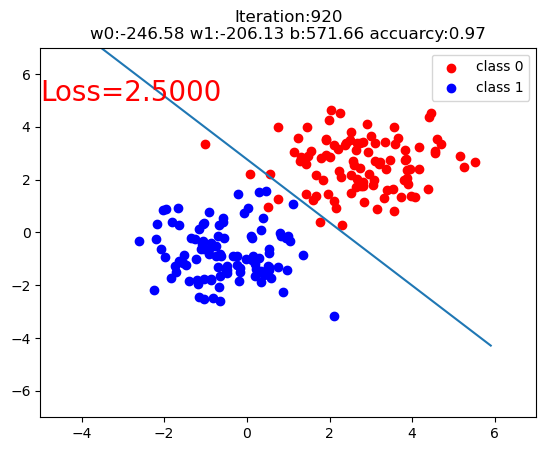

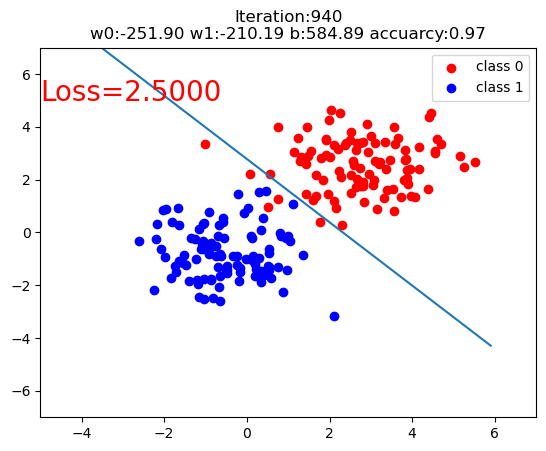

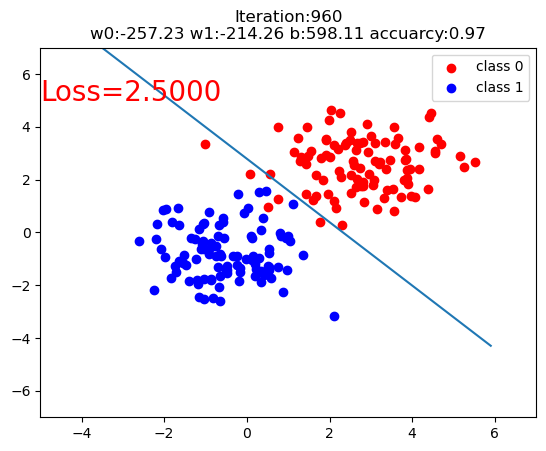

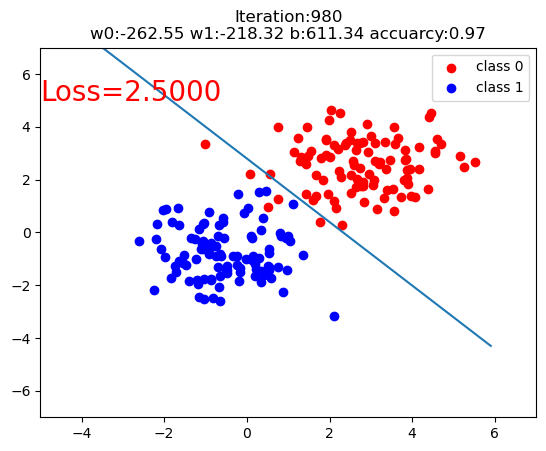

In [47]:
#选择模型
class LR(nn.Module):
    def __init__(self):
        super(LR,self).__init__()
        self.features = nn.Linear(2,1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        x = self.features(x)
        x = self.sigmoid(x)
        return x
    
    
lr_net = LR() #实例化逻辑回归模型

#选择Loss function
loss_fn = nn.BCELoss()

#选择优化器
lr = 0.01
optimizer = torch.optim.SGD(lr_net.parameters(),lr=lr,momentum=0.9)

#训练模型
for iteration in range(1000):
    
    y_pred = lr_net(train_x)
    loss = loss_fn(y_pred.squeeze(),train_y)
    loss.backward()
    optimizer.step()
    
    if iteration %20 ==0:
        mask = y_pred.ge(0.5).float().squeeze()
        correct = (mask == train_y).sum()
        acc = correct.item()/train_y.size(0)
        
        plt.scatter(x0.data.numpy()[:,0],x0.data.numpy()[:,1],c='r',label='class 0')
        plt.scatter(x1.data.numpy()[:,0],x1.data.numpy()[:,1],c='b',label='class 1')
        
        w0,w1 = lr_net.features.weight[0]
        w0,w1 = float(w0.item()),float(w1.item())
        plot_b = float(lr_net.features.bias[0].item())
        plot_x = np.arange(-6,6,0.1)
        plot_y = (-w0*plot_x-plot_b)/w1
        
        plt.xlim(-5,7)
        plt.ylim(-7,7)
        plt.plot(plot_x,plot_y)
        
        plt.text(-5,5,'Loss=%.4f'% loss.data.numpy(),fontdict={'size':20,'color':'red'})
        plt.title('Iteration:{}\nw0:{:.2f} w1:{:.2f} b:{:.2f} accuarcy:{:.2f}'.format(iteration,w0,w1,plot_b,acc))
        plt.legend()
        plt.show()
        plt.pause(0.2)
        
        if acc>0.99:
            break